In [13]:
import pandas as pd
import numpy as np
import os
import requests
import feedparser
import time
import json
from tqdm import tqdm

In [189]:
# Let's get abstracts from 1000 recent papers for each of the following 6 arXiv categories:
# --> Physics, Mathematics, Computer Science, Quantitative Biology, Statistics, Economics

#### ---- https://arxiv.org/help/api/user-manual---- ####
# In cases where the API needs to be called multiple times in a row, we encourage you to 
# play nice and incorporate a 3 second delay in your code. The detailed examples below 
# illustrate how to do this in a variety of languages.
# Note	Because of speed limitations in our implementation of the API, the maximum number 
# of results returned from a single call (max_results) is limited to 30000 in slices of at 
# most 2000 at a time, using the max_results and start query parameters.

def get_arXiv_papers(search_term, num_calls=5, max_results=1000):
    '''
    USAGE:
    Get info from the arXiv for a number (default 5000) of papers matching
    a specified search term.
    
    ARGUMENTS:
    search_term - term to search in the arXiv
    num_calls - number of calls to make to arXiv API
    max_results - maximum number of results per call
    
    RETURNS:
    entries - list of results from the request
    '''

    print('Getting papers...')
    url_base = 'http://export.arxiv.org/api/query?search_query='
    entries = []

    i = 0
    while i < num_calls:
        start = i * max_results
        assert start + max_results <= 30000
        url_query = 'all=%s&start=%d&max_results=%d'% (search_term, start, max_results)
        url = url_base + url_query
        print(url)

        response = requests.get(url)
        
        # Sometimes fails, but returns status_code 200 anyway. Not sure why.
        # Make sure that new data is really retrieved... 
        
        before = len(entries)
        entries += feedparser.parse(response.content).entries
        after = len(entries)

        # If we successfully get new papers...
        if after > before:
            i += 1

        print('Total number retrieved: %d' % len(entries))

        time.sleep(3) # Wait 3 seconds between requests

    print('Papers retrieved.')
    return entries
    
entries = get_arXiv_papers('the')

Getting papers...
http://export.arxiv.org/api/query?search_query=all=the&start=0&max_results=1000
Total number retrieved: 1000
http://export.arxiv.org/api/query?search_query=all=the&start=1000&max_results=1000
Total number retrieved: 2000
http://export.arxiv.org/api/query?search_query=all=the&start=2000&max_results=1000
Total number retrieved: 3000
http://export.arxiv.org/api/query?search_query=all=the&start=3000&max_results=1000
Total number retrieved: 4000
http://export.arxiv.org/api/query?search_query=all=the&start=4000&max_results=1000
Total number retrieved: 5000
Papers retrieved.


In [237]:
folder = 'papers_from_arXiv'
file_name = 'arXiv_papers.json'
file_path = os.path.join(folder, file_name)

def write_to_JSON(data, file_path):

    print('Writing to file...')
    with open(file_path, 'w') as fp:
        json.dump(data, fp)
    print('Data written to "%s".' % file_path)

write_to_JSON(entries, file_path)

Writing to file...
Data written to "papers_from_arXiv\arXiv_papers.json".


In [7]:
def load_papers(file_path):
    '''
    USAGE: 
    Load paper info from file and generate a DataFrame and list of categories.
    
    ARGUMENT: 
    file_path - location of file
    
    RETURNS: 
    terms - list of paper categories
    df - Pandas DataFrame with columns ['term', 'title', 'summary', 'id']
    '''
    
    print('Loading data from file...')
    with open(file_path, 'r') as fp:
        entries = json.load(fp)

    df = pd.DataFrame(entries)
    terms = []
    for k in range(len(df.arxiv_primary_category)):
        term = df.iloc[k].arxiv_primary_category['term']
        terms.append(term.split('.')[0])
        
    df['term'] = terms
    df = df[['term', 'title', 'summary', 'id']]
    
    print('DataFrame generated from "%s".' % file_path)
    return terms, df

terms, df = load_papers(file_path)

Loading data from file...
DataFrame generated from "papers_from_arXiv\arXiv_papers.json".


In [8]:
def get_top_terms(terms, num=10):
    '''
    USAGE: Make a list of top paper categories.
    
    ARGUMENTS: 
    terms - list of all paper categories ("terms")
    num - number of categories to keep
    
    RETURNS:
    top_terms - list of names of most frequent categories
    '''

    term_dict = {}
    for term in terms:
        if term in term_dict:
            term_dict[term] += 1
        else:
            term_dict[term] = 1

    term_dict_rev = dict(zip(list(term_dict.values()), list(term_dict.keys())))
    counts_thresh = sorted(list(term_dict_rev.keys()))[-num]
    top_terms = [term_dict_rev[x] for x in term_dict_rev if x >= counts_thresh]
    return top_terms

top_terms = get_top_terms(terms)

In [9]:
def prune_df(df, top_terms):
    '''
    USAGE: Prune DataFrame to include papers only from most common categories
    
    ARGUMENTS:
    df - DataFrame of paper info
    top_terms - list of most frequent categories
    
    RETURNS:
    pruned_df - pruned paper DataFrame
    '''
    pruned_df = df[df['term'].isin(top_terms)]
    return pruned_df

df = prune_df(df, top_terms)

In [10]:
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()

def abstract2df(df_small, idx):
    '''
    USAGE: Use Porter Stemming to process a paper abstract.
    
    ARGUMENT: 
    df - DataFrame with keys ["term", "title", "summary", "id"]
    idx - index locating paper within DataFrame
    
    RETURNS: stem_df - DataFrame with keys ["stems", "counts", "docs"]
    '''
    abstract = df.iloc[idx].summary
    words = word_tokenize(abstract)
    stems = [ps.stem(w).lower() for w in words]
    counts = Counter(stems)
    docs = list(np.ones(len(counts)).astype(int))
    stem_df = pd.DataFrame({'stems': list(counts.keys()), 'counts': list(counts.values()), 'docs': docs})
    stem_df = stem_df[['stems', 'counts', 'docs']]
    return stem_df

def count_stems(df):
    '''
    USAGE:
    Count up total number of occurrences of each word stem that appears in the df 
    DataFrame, and count up the numer of documents each of those word stems appears in.
    
    ARGUMENTS:
    df - DataFrame with keys ["term", "title", "summary", "id"]
    
    RETURNS:
    full_stem_df - DataFrame with keys ["stems", "counts", "docs"] sorted by "counts"
    '''
    
    print('Counting word stems in %d abstracts...' % len(df))
    full_stem_df = pd.DataFrame()
    for idx in range(len(df)):
        stem_df = abstract2df(df, idx)
        full_stem_df = pd.concat([full_stem_df, stem_df])
        if idx and idx % 10 == 0 or idx == len(df) - 1:
            full_stem_df = full_stem_df.groupby('stems').sum()
            full_stem_df['stems'] = full_stem_df.index
            full_stem_df = full_stem_df[['stems', 'counts', 'docs']]
    
    full_stem_df.sort_values('counts', ascending=False, inplace=True)
    print('Stems counted.')
    return full_stem_df

all_stems = count_stems(df)

Counting word stems in 4583 abstracts...
Stems counted.


In [11]:
def docs2idf(df, num):
    '''
    USAGE: 
    Get an inverse document frequency (idf) measure for each stem, 
    and add that measure to the word stem DataFrame.
    
    ARGUMENTS:
    df - word stem DataFrame
    num - total number of papers in document pool
    '''
    df['idf'] = np.log(num/df['docs'])
    return df

all_stems = docs2idf(all_stems, len(df))

In [14]:
def papers2matrix(stems, samples):
    '''
    USAGE:
    Embed a selection of paper abstracts in a high-dimensional space where each 
    dimension represents the "term frequency-inverse document frequency" (tf-idf) of a 
    given word stem. The tf-idf is a product of the {relative frequency with which a 
    term appears in a single document} and the log of the {total number of papers in
    the document pool divided by the number of documents in which a term appears}.
    
    ARGUMENTS:
    stems - DataFrame of word stems in our dataset 
    samples - number of abstracts to embed
    
    RETURNS:
    matrix - 2D array of embedded paper-abstract row vectors
    info - list of ['id', 'term', 'title'] lists corresponding to each paper embedded
    '''
    
    assert samples <= len(df)
    
    idf = np.array(list(stems['idf']))
    stems = stems[['stems', 'idf']]
    matrix = np.zeros((samples, len(stems)))
    info = []
    
    print('Embedding paper abstracts...')
    
    i = 0
    for idx in tqdm(range(samples)):
    
        information = list(df.iloc[idx][['id', 'term', 'title']])
        info.append(information)
                
        new_df = pd.merge(stems, abstract2df(df, idx), on='stems', how='left').fillna(0)
        
        vec = np.array(list(new_df['counts']))
        vec /= np.sum(vec) # components sum to 1
        vec *= idf         # apply inverse document frequency
        matrix[i, :] = vec
        
        i += 1
    
    print('Paper abstracts converted to vectors.')
    
    return matrix, info

matrix, info = papers2matrix(all_stems, len(df))

Embedding paper abstracts...


100%|████████████████████████████████████████████| 4583/4583 [02:20<00:00, 32.63it/s]


Paper abstracts converted to vectors.


In [19]:
## Note: dimensionality reduction --> PCA for dense data, TruncatedSVD for sparse data
## (http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from time import time

def reduce_dim(matrix, dims):
    '''
    USAGE: Perform Truncated SVD to reduce dimensionality of embedding space.
    
    ARGUMENTS: 
    matrix - training data (sparse matrix) with shape (n_features, n_samples)
    dims - number of dimensions to project data into
    
    RETURNS:
    X_new - array of reduced dimensionality
    '''
    
    tic =time()
    print('Performing Truncated SVD...')
    svd = TruncatedSVD(n_components = dims, random_state = 1)
    X = svd.fit_transform(matrix) # matrix.shape = (n_samples, n_features)
    toc = time()
    print('Embeddings reduced from %d to %d dimensions through TruncatedSVD. (Time elapsed: %.2f s)' 
          % (matrix.shape[1], dims, (toc-tic)))
    return X

# with X_embedded.shape = (5000, 128), perplexity = 30, elapsed TSNE time ~ 5 minutes.
def TSNE2D(X):
    '''
    USAGE: Perform TSNE to reduce embedding space to 2D
    ARGUMENT: X - high-dimensional training array (n_samples, n_features ~ 100)
    RETURNS: X_embedded - 2D matrix (n_samples, 2)
    '''
    
    tic = time()
    print('Performing TSNE...')
    X_embedded = TSNE(n_components=2, perplexity=30, random_state = 1).fit_transform(X)
    toc = time()
    print('Embeddings reduced to 2 dimensions through TSNE. (Time elapsed: %.2f s)' % (toc-tic))
    return X_embedded

X = reduce_dim(matrix, 128)
X_embedded = TSNE2D(X)

Performing Truncated SVD...
Embeddings reduced from 19910 to 128 dimensions through TruncatedSVD. (Time elapsed: 22.18 s)
Performing TSNE...
Embeddings reduced to 2 dimensions through TSNE. (Time elapsed: 240.18 s)


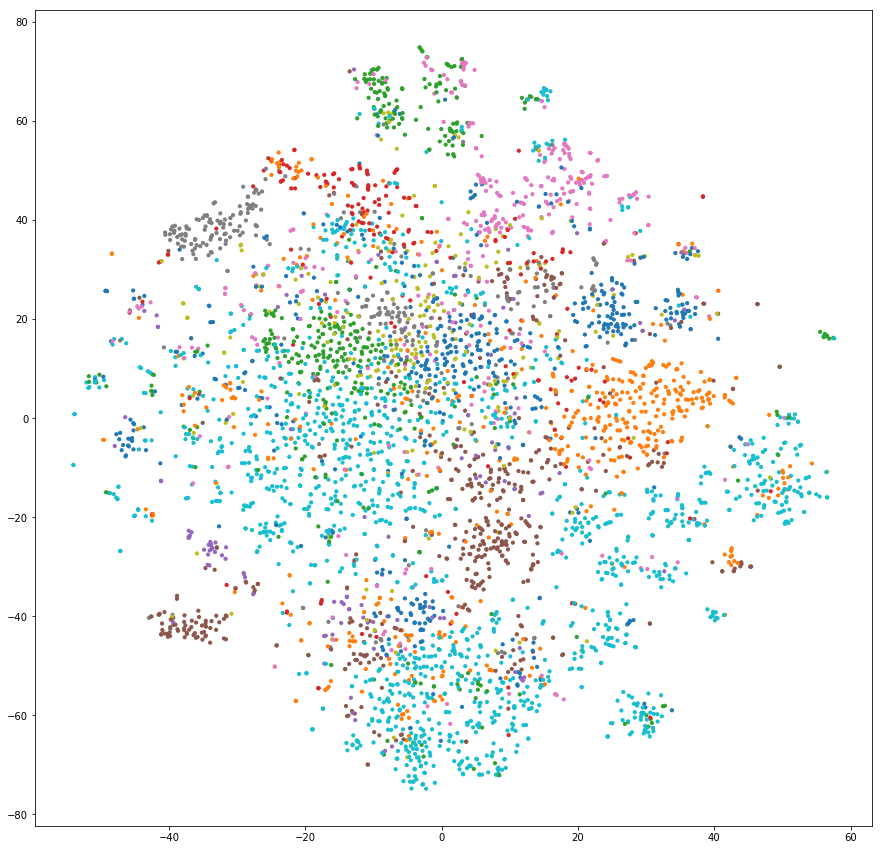

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm

def plot_2D(X, info):
    '''
    USAGE: 
    Create scatter plot of points in array with shape (n_samples, 2)
    
    ARGUMENTS: 
    X - 2D array of shape (n_samples, 2)
    info - list of ['id', 'term', 'title'] lists corresponding to each paper embedded 
    '''
    x = X[:, 0]
    y = X[:, 1]
    
    term_list = list(np.array(info).T[1])
    term_set = list(set(term_list))
    term_list = [term_set.index(term) for term in term_list]
    
    color_list = plt.cm.tab10(term_list)
    
    plt.figure(figsize = (15,15))
    plt.scatter(x,y, s = 10, c = color_list)
    plt.show()
    
plot_2D(X_embedded, info)

In [21]:
name = 'embedding'
destination = os.path.join('papers_from_arXiv', 'processed', name + '_0.json')

def get_filepath(filepath):
    '''
    USAGE: Iterate filepath suffix index up by 1 if filename is already taken.
    ARGUMENT: filepath - string with format (root + num + .extension)
    RETURNS: returns filepath if it doesn't exist, otherwise, executes function again.
    '''
    if not os.path.exists(filepath):
        return filepath 
    else:
        root = "_".join(filepath.split('_')[:-1]) + '_'
        num = int(filepath.split('_')[-1].split('.')[0])
        ext = '.' + filepath.split('.')[1]
        new_path = '%s%d%s' % (root, num + 1, ext)
        return get_filepath(new_path)

def export_data(X, info, destination):
    '''
    USAGE: 
    Export embeddings and their info to JSON file.
    
    ARGUMENTS:
    X - list of [x, y] lists of coordinates
    info - list of ['id', 'term', 'title'] lists corresponding to each paper embedded
    '''
    destination = get_filepath(destination)
    categories = dict(zip(top_terms, [x for x in range(len(top_terms))]))
    data = {'X': X.tolist(), 'info': info, 'categories': categories}
    with open(destination, 'w') as fp:
        json.dump(data, fp)
    print('Processed data exported to "%s".' % destination)
    
export_data(X_embedded, info, destination)

FileNotFoundError: [Errno 2] No such file or directory: 'papers_from_arXiv\\processed\\embedding_0.json'